In [2]:
#!pip3 install tensorflow
#!pip3 install tensorflow_hub
#!pip3 install tensorflow_addons
#!pip3 install pandarallel
#!pip3 install opencv-python
#!pip3 install scipy
#!pip3 install kaggle
!pip3 install modules

  Preparing metadata (setup.py) ... done
  Created wheel for modules: filename=modules-1.0.0-py3-none-any.whl size=1222 sha256=8d9e2974fe1183cd68d695e875fdd2d4307ee820ac7c485df8fe6ad22aedd19d
  Stored in directory: /root/.cache/pip/wheels/05/fb/b9/38f6beca84a9886bbad5f607ec36b7ab8eca58b4df2b4d1cf3
Successfully built modules


In [3]:
#Importing Relevant Packages
import tensorflow as tf
import tensorflow_hub as tfhub
import tensorflow_addons as tfa
import pandas as pd
import numpy as np

import sklearn
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from pandarallel import pandarallel
from sklearn.model_selection import GroupKFold, StratifiedKFold
from scipy.spatial import cKDTree

In [4]:
from collections import Counter
from datetime import datetime
from glob import glob
import modules
import warnings
import requests
import hashlib
import imageio
import IPython
import urllib
import zipfile
import pickle
import random
import shutil
import string
import json
import math
import time
import gzip
import ast
import sys
import io
import os
import gc
import re

In [5]:
#Importing packages for Visualization
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm; tqdm.pandas();
import plotly.express as px
import seaborn as sns
from PIL import Image, ImageEnhance
import matplotlib; print(f"\t\t– MATPLOTLIB VERSION: {matplotlib.__version__}");
from matplotlib import animation, rc; rc('animation', html='jshtml')
import plotly
import PIL
import cv2

import plotly.io as pio
print(pio.renderers)

		– MATPLOTLIB VERSION: 3.5.3
Renderers configuration
-----------------------
    Default renderer: 'kaggle'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']



In [6]:
DATA_DIR = "/kaggle/input/uw-madison-gi-tract-image-segmentation"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
train_df = pd.read_csv(TRAIN_CSV)

In [7]:
all_train_images = glob(os.path.join(TRAIN_DIR, "**", "*.png"), recursive=True)
all_train_images[:5]

['/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0006_266_266_1.50_1.50.png',
 '/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0082_266_266_1.50_1.50.png',
 '/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0113_266_266_1.50_1.50.png',
 '/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0076_266_266_1.50_1.50.png',
 '/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0125_266_266_1.50_1.50.png']

In [8]:
SS_CSV   = os.path.join(DATA_DIR, "sample_submission.csv")
ss_df = pd.read_csv(SS_CSV)

SF2LF = {"lb":"Large Bowel","sb":"Small Bowel","st":"Stomach"}
LF2SF = {v:k for k,v in SF2LF.items()}

**Data-Preprocessing**

In [9]:
# Reading Case-ID as column
train_df["case_id_str"] = train_df["id"].apply(lambda x: x.split("_", 2)[0])
train_df["case_id"] = train_df["id"].apply(lambda x: int(x.split("_", 2)[0].replace("case", "")))

# Fetching day as column
train_df["day_num_str"] = train_df["id"].apply(lambda x: x.split("_", 2)[1])
train_df["day_num"] = train_df["id"].apply(lambda x: int(x.split("_", 2)[1].replace("day", "")))

# Slice Details
train_df["slice_id"] = train_df["id"].apply(lambda x: x.split("_", 2)[2])

# Full file paths for scans
train_df["_partial_ident"] = (TRAIN_DIR+"/"+ 
                             train_df["case_id_str"]+"/"+
                             train_df["case_id_str"]+"_"+train_df["day_num_str"]+
                             "/scans/"+train_df["slice_id"])
_tmp_merge_df = pd.DataFrame({"_partial_ident":[x.rsplit("_",4)[0] for x in all_train_images], "f_path":all_train_images})
train_df = train_df.merge(_tmp_merge_df, on="_partial_ident").drop(columns=["_partial_ident"])

del _tmp_merge_df; gc.collect(); gc.collect()

# Slice Dimensions from filepath
train_df["slice_h"] = train_df["f_path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
train_df["slice_w"] = train_df["f_path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))

# Pixel Spacing from filepath
train_df["px_spacing_h"] = train_df["f_path"].apply(lambda x: float(x[:-4].rsplit("_",4)[3]))
train_df["px_spacing_w"] = train_df["f_path"].apply(lambda x: float(x[:-4].rsplit("_",4)[4]))

# Merging rows into single row
l_bowel_train_df = train_df[train_df["class"]=="large_bowel"][["id", "segmentation"]].rename(columns={"segmentation":"lb_seg_rle"})
s_bowel_train_df = train_df[train_df["class"]=="small_bowel"][["id", "segmentation"]].rename(columns={"segmentation":"sb_seg_rle"})
stomach_train_df = train_df[train_df["class"]=="stomach"][["id", "segmentation"]].rename(columns={"segmentation":"st_seg_rle"})
train_df = train_df.merge(l_bowel_train_df, on="id", how="left")
train_df = train_df.merge(s_bowel_train_df, on="id", how="left")
train_df = train_df.merge(stomach_train_df, on="id", how="left")
train_df = train_df.drop_duplicates(subset=["id",]).reset_index(drop=True)
train_df["lb_seg_flag"] = train_df["lb_seg_rle"].apply(lambda x: not pd.isna(x))
train_df["sb_seg_flag"] = train_df["sb_seg_rle"].apply(lambda x: not pd.isna(x))
train_df["st_seg_flag"] = train_df["st_seg_rle"].apply(lambda x: not pd.isna(x))
train_df["n_segs"] = train_df["lb_seg_flag"].astype(int)+train_df["sb_seg_flag"].astype(int)+train_df["st_seg_flag"].astype(int)

# Reordering columns for convenience
train_df = train_df[["id", "f_path", "n_segs",
                     "lb_seg_rle", "lb_seg_flag",
                     "sb_seg_rle", "sb_seg_flag", 
                     "st_seg_rle", "st_seg_flag",
                     "slice_h", "slice_w", "px_spacing_h", 
                     "px_spacing_w", "case_id_str", "case_id", 
                     "day_num_str", "day_num", "slice_id",]]
# Updated Dataframe
print("\n... UPDATING TRAINING DATAFRAME... \n")
display(train_df)



... UPDATING TRAINING DATAFRAME... 



,id,f_path,n_segs,lb_seg_rle,lb_seg_flag,sb_seg_rle,sb_seg_flag,st_seg_rle,st_seg_flag,slice_h,slice_w,px_spacing_h,px_spacing_w,case_id_str,case_id,day_num_str,day_num,slice_id
0,case123_day20_slice_0001,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case123,123,day20,20,slice_0001
1,case123_day20_slice_0002,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case123,123,day20,20,slice_0002
2,case123_day20_slice_0003,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case123,123,day20,20,slice_0003
3,case123_day20_slice_0004,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case123,123,day20,20,slice_0004
4,case123_day20_slice_0005,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case123,123,day20,20,slice_0005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38491,case30_day0_slice_0140,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case30,30,day0,0,slice_0140
38492,case30_day0_slice_0141,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case30,30,day0,0,slice_0141
38493,case30_day0_slice_0142,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case30,30,day0,0,slice_0142
38494,case30_day0_slice_0143,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case30,30,day0,0,slice_0143


In [10]:
def rle_decode(mask_rle, shape, color=1):
    '''
    Returns: mask where 
            - 1 indicating mask
            - 0 indicating background
    '''
    # Split the string by space, then convert it into a integer array
    s = np.array(mask_rle.split(), dtype=int)

    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths

    # The image image is actually flattened since RLE is a 1D "run"
    if len(shape)==3:
        h, w, d = shape
        img = np.zeros((h * w, d), dtype=np.float32)
    else:
        h, w = shape
        img = np.zeros((h * w,), dtype=np.float32)

    # The color here is actually just any integer you want!
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
        
    # Don't forget to change the image back to the original shape
    return img.reshape(shape)


In [11]:
def rle_decode_top_to_bot_first(mask_rle, shape):
    '''
    Returns: mask where
            - 1 indicating mask
            - 0 indicating background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape((shape[1], shape[0]), order='F').T

def rle_encode(img):
    '''
    Returns: run length as string formated
    '''
    
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def flatten_l_o_l(nested_list):
    '''Flatten a list of lists'''
    return [item for sublist in nested_list for item in sublist]

def load_json_to_dict(json_path):
    with open(json_path) as json_file:
        data = json.load(json_file)
    return data

def tf_load_png(img_path):
    return tf.image.decode_png(tf.io.read_file(img_path), channels=3)

def open_gray16(_path, normalize=True, to_rgb=False):
    if normalize:
        if to_rgb:
            return np.tile(np.expand_dims(cv2.imread(_path, cv2.IMREAD_ANYDEPTH)/65535., axis=-1), 3)
        else:
            return cv2.imread(_path, cv2.IMREAD_ANYDEPTH)/65535.
    else:
        if to_rgb:
            return np.tile(np.expand_dims(cv2.imread(_path, cv2.IMREAD_ANYDEPTH), axis=-1), 3)
        else:
            return cv2.imread(_path, cv2.IMREAD_ANYDEPTH)
    

In [12]:
def get_overlay(img_path, rle_strs, img_shape, _alpha=0.999, _beta=0.35, _gamma=0):
    _img = open_gray16(img_path, to_rgb=True)
    _img = ((_img-_img.min())/(_img.max()-_img.min())).astype(np.float32)
    _seg_rgb = np.stack([rle_decode(rle_str, shape=img_shape, color=1) if rle_str is not None else np.zeros(img_shape, dtype=np.float32) for rle_str in rle_strs], axis=-1).astype(np.float32)
    seg_overlay = cv2.addWeighted(src1=_img, alpha=_alpha, 
                                  src2=_seg_rgb, beta=_beta, gamma=_gamma)
    return seg_overlay

def examine_id(ex_id, df=train_df, plot_overlay=True, print_meta=False, plot_grayscale=False, plot_binary_segmentation=False):
    '''Wrapper function to allow for easy visual exploration of an example'''
    print(f"\n... ID ({ex_id}) EXPLORATION BEGINS ...\n\n")
    demo_ex = df[df.id==ex_id].squeeze()

    if print_meta:
        print(f"\n... WITH DEMO_ID=`{DEMO_ID}`\n\n")
        display(demo_ex.to_frame())

    if plot_grayscale:
        print(f"\n\n... GRAYSCALE IMAGE PLOT ...\n")
        plt.figure(figsize=(12,12))
        plt.imshow(open_gray16(demo_ex.f_path), cmap="gray")
        plt.title(f"Original Grayscale Image For ID: {demo_ex.id}", fontweight="bold")
        plt.axis(False)
        plt.show()

    if plot_binary_segmentation:
        print(f"\n\n... BINARY SEGMENTATION MASKS ...\n")
        plt.figure(figsize=(20,10))
        for i, _seg_type in enumerate(["lb", "sb", "st"]):
            if pd.isna(demo_ex[f"{_seg_type}_seg_rle"]): continue
            plt.subplot(1,3,i+1)
            plt.imshow(rle_decode(demo_ex[f"{_seg_type}_seg_rle"], shape=(demo_ex.slice_w, demo_ex.slice_h), color=1))
            plt.title(f"RLE Encoding For {SF2LF[_seg_type]} Segmentation", fontweight="bold")
            plt.axis(False)
        plt.tight_layout()
        plt.show()

    if plot_overlay:
        print(f"\n\n... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...\n")
    
        _rle_strs = [demo_ex[f"{_seg_type}_seg_rle"] if not pd.isna(demo_ex[f"{_seg_type}_seg_rle"]) else None for _seg_type in ["lb", "sb", "st"]]
        seg_overlay = get_overlay(demo_ex.f_path, _rle_strs, img_shape=(demo_ex.slice_w, demo_ex.slice_h))

        plt.figure(figsize=(12,12))
        plt.imshow(seg_overlay)
        plt.title(f"Segmentation Overlay For ID: {demo_ex.id}", fontweight="bold")
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel Segmentation Map", "Small Bowel Segmentation Map", "Stomach Segmentation Map"]
        plt.legend(handles,labels)
        plt.axis(False)
        plt.show()

    print("\n\n... SINGLE ID EXPLORATION COMPLETED ...\n\n")
            

In [13]:
## To find the case scan which contains lb, sb and stomach segmentation

train_mask = (train_df['lb_seg_flag'] == True) & (train_df['sb_seg_flag'] == True) & (train_df['st_seg_flag'] == True) & (train_df['case_id_str'] == 'case108')
train_df[train_mask][-8:]

,id,f_path,n_segs,lb_seg_rle,lb_seg_flag,sb_seg_rle,sb_seg_flag,st_seg_rle,st_seg_flag,slice_h,slice_w,px_spacing_h,px_spacing_w,case_id_str,case_id,day_num_str,day_num,slice_id
24641,case108_day13_slice_0082,/kaggle/input/uw-madison-gi-tract-image-segmen...,3,17959 9 18223 17 18244 3 18488 27 18754 33 190...,True,21978 20 22242 24 22506 27 22771 30 23037 31 2...,True,24313 6 24577 12 24841 17 25106 20 25371 22 25...,True,266,266,1.5,1.5,case108,108,day13,13,slice_0082
24642,case108_day13_slice_0083,/kaggle/input/uw-madison-gi-tract-image-segmen...,3,17693 4 17957 8 18221 18 18485 24 18749 29 190...,True,21976 12 22240 27 22505 30 22770 33 23035 36 2...,True,24578 9 24841 14 25105 18 25370 20 25635 22 25...,True,266,266,1.5,1.5,case108,108,day13,13,slice_0083
24643,case108_day13_slice_0084,/kaggle/input/uw-madison-gi-tract-image-segmen...,3,17694 1 17957 7 18221 18 18484 24 18691 4 1874...,True,21715 6 21976 15 21996 5 22240 30 22504 35 227...,True,24844 6 25107 12 25371 16 25635 19 25899 21 26...,True,266,266,1.5,1.5,case108,108,day13,13,slice_0084
24644,case108_day13_slice_0085,/kaggle/input/uw-madison-gi-tract-image-segmen...,3,17960 3 18222 13 18425 3 18483 24 18689 7 1874...,True,21715 11 21730 5 21978 26 22241 32 22505 36 22...,True,25111 2 25374 8 25638 12 25901 16 26165 19 264...,True,266,266,1.5,1.5,case108,108,day13,13,slice_0085
24645,case108_day13_slice_0086,/kaggle/input/uw-madison-gi-tract-image-segmen...,3,18224 10 18425 4 18484 21 18689 8 18748 26 189...,True,21465 1 21716 20 21979 26 22244 30 22508 34 22...,True,25641 4 25904 9 26167 13 26431 16 26695 18 269...,True,266,266,1.5,1.5,case108,108,day13,13,slice_0086
24646,case108_day13_slice_0087,/kaggle/input/uw-madison-gi-tract-image-segmen...,3,18226 5 18425 4 18486 16 18689 9 18747 23 1895...,True,21465 1 21718 17 21981 23 22245 29 22510 32 22...,True,26172 3 26435 8 26698 12 26962 14 27226 16 274...,True,266,266,1.5,1.5,case108,108,day13,13,slice_0087
24647,case108_day13_slice_0088,/kaggle/input/uw-madison-gi-tract-image-segmen...,3,18489 11 18691 8 18741 27 18955 13 19002 34 19...,True,21724 9 21984 17 22248 23 22487 9 22513 28 227...,True,26703 1 26965 7 27229 10 27493 13 27758 14 280...,True,266,266,1.5,1.5,case108,108,day13,13,slice_0088
24648,case108_day13_slice_0089,/kaggle/input/uw-madison-gi-tract-image-segmen...,3,18492 2 18741 25 18956 11 19003 31 19219 17 19...,True,21993 6 22222 7 22252 15 22486 12 22516 23 227...,True,27498 4 27761 9 28025 11 28290 13 28555 14 288...,True,266,266,1.5,1.5,case108,108,day13,13,slice_0089



... SINGLE ID EXPLORATION BEGINS ...



... WITH DEMO_ID=`case108_day13_slice_0084`




,24643
id,case108_day13_slice_0084
f_path,/kaggle/input/uw-madison-gi-tract-image-segmen...
n_segs,3
lb_seg_rle,17694 1 17957 7 18221 18 18484 24 18691 4 1874...
lb_seg_flag,True
sb_seg_rle,21715 6 21976 15 21996 5 22240 30 22504 35 227...
sb_seg_flag,True
st_seg_rle,24844 6 25107 12 25371 16 25635 19 25899 21 26...
st_seg_flag,True
slice_h,266




... PLOTTING IMAGE ...



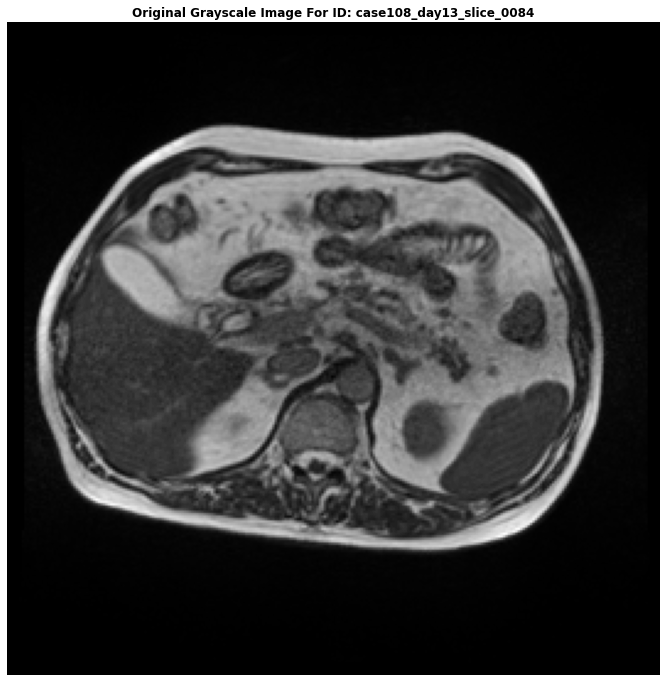



... PLOTTING 3 SEGMENTATION MASKS ...



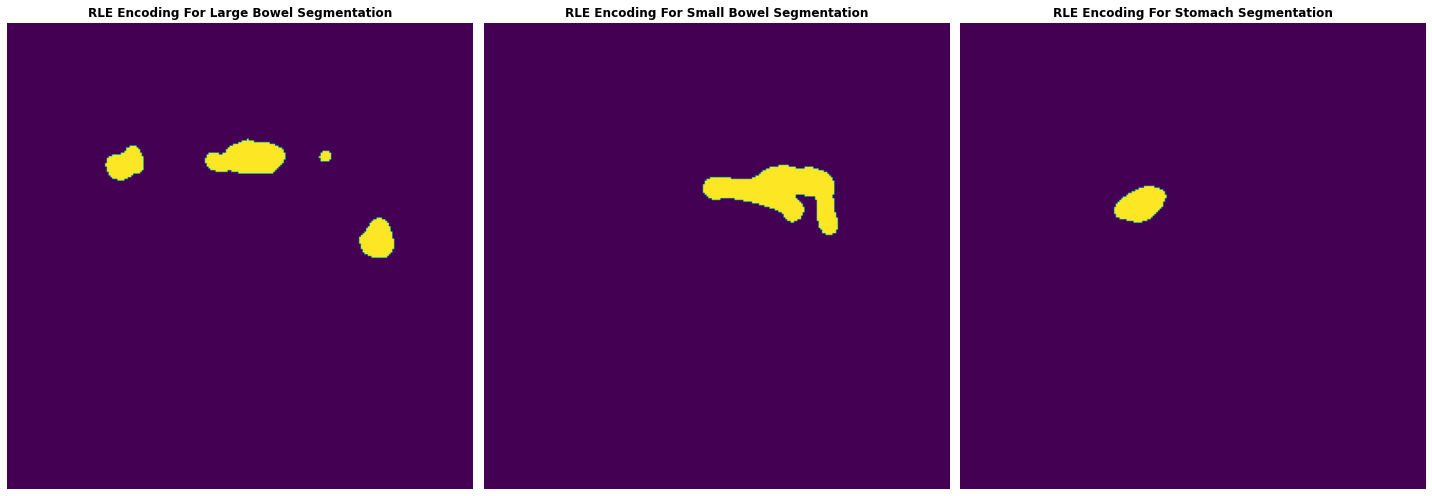



... PLOTTING THE IMAGE WITH AN RGB SEGMENTATION MASK OVERLAY ...



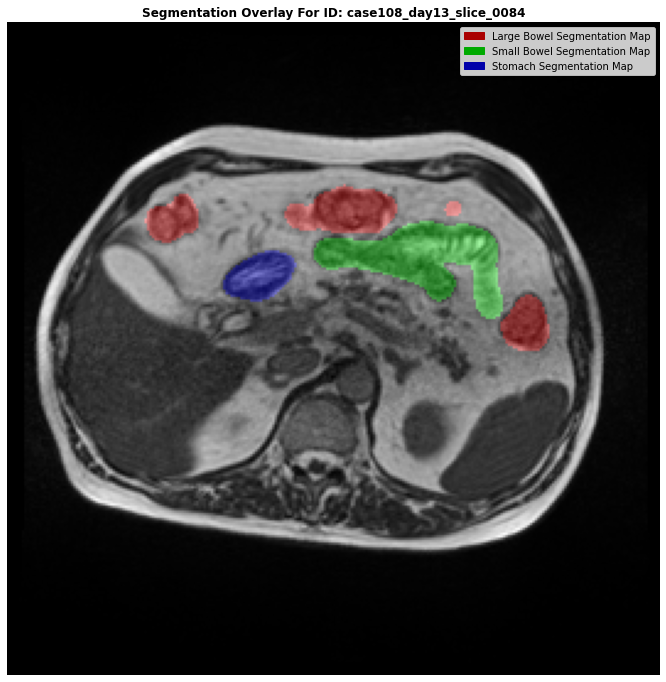



... INFORMATION PERTAINING TO IMAGE ...

	--> IMAGE CASE ID              : 108
	--> IMAGE DAY NUMBER           : 13
	--> IMAGE SLICE WIDTH          : 266
	--> IMAGE SLICE HEIGHT         : 266
	--> IMAGE PIXEL SPACING WIDTH  : 1.5
	--> IMAGE PIXEL SPACING HEIGHT : 1.5


... SINGLE ID EXPLORATION COMPLETED ...




In [14]:
print("\n... SINGLE ID EXPLORATION BEGINS ...\n\n")

DEMO_ID = "case108_day13_slice_0084"   #Using from above analysis of segments
demo_ex = train_df[train_df.id==DEMO_ID].squeeze()

print(f"\n... WITH DEMO_ID=`{DEMO_ID}`\n\n")
display(demo_ex.to_frame())

print(f"\n\n... PLOTTING IMAGE ...\n")
plt.figure(figsize=(12,12))
plt.imshow(open_gray16(demo_ex.f_path), cmap="gray")
plt.title(f"Original Grayscale Image For ID: {demo_ex.id}", fontweight="bold")
plt.axis(False)
plt.show()

print(f"\n\n... PLOTTING 3 SEGMENTATION MASKS ...\n")

plt.figure(figsize=(20,10))
for i, _seg_type in enumerate(["lb", "sb", "st"]):
    if pd.isna(demo_ex[f"{_seg_type}_seg_rle"]): continue
    plt.subplot(1,3,i+1)
    plt.imshow(rle_decode(demo_ex[f"{_seg_type}_seg_rle"], shape=(demo_ex.slice_w, demo_ex.slice_h), color=1))
    plt.title(f"RLE Encoding For {SF2LF[_seg_type]} Segmentation", fontweight="bold")
    plt.axis(False)
plt.tight_layout()
plt.show()

print(f"\n\n... PLOTTING THE IMAGE WITH AN RGB SEGMENTATION MASK OVERLAY ...\n")


_img = open_gray16(demo_ex.f_path, to_rgb=True)
_img = ((_img-_img.min())/(_img.max()-_img.min())).astype(np.float32)
_seg_rgb = np.stack([rle_decode(demo_ex[f"{_seg_type}_seg_rle"], shape=(demo_ex.slice_w, demo_ex.slice_h), color=1) if not pd.isna(demo_ex[f"{_seg_type}_seg_rle"]) else np.zeros((demo_ex.slice_w, demo_ex.slice_h)) for _seg_type in ["lb", "sb", "st"]], axis=-1).astype(np.float32)
seg_overlay = cv2.addWeighted(src1=_img, alpha=0.99, 
                              src2=_seg_rgb, beta=0.33, gamma=0.0)
plt.figure(figsize=(12,12))
plt.imshow(seg_overlay)
plt.title(f"Segmentation Overlay For ID: {demo_ex.id}", fontweight="bold")
handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
labels = ["Large Bowel Segmentation Map", "Small Bowel Segmentation Map", "Stomach Segmentation Map"]
plt.legend(handles,labels)
plt.axis(False)
plt.show()

print(f"\n\n... INFORMATION PERTAINING TO IMAGE ...\n")
print(f"\t--> IMAGE CASE ID              : {demo_ex.case_id}")
print(f"\t--> IMAGE DAY NUMBER           : {demo_ex.day_num}")
print(f"\t--> IMAGE SLICE WIDTH          : {demo_ex.slice_w}")
print(f"\t--> IMAGE SLICE HEIGHT         : {demo_ex.slice_h}")
print(f"\t--> IMAGE PIXEL SPACING WIDTH  : {demo_ex.px_spacing_w}")
print(f"\t--> IMAGE PIXEL SPACING HEIGHT : {demo_ex.px_spacing_h}")

print("\n\n... SINGLE ID EXPLORATION COMPLETED ...\n\n")


... ID (case40_day17_slice_0087) EXPLORATION BEGINS ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



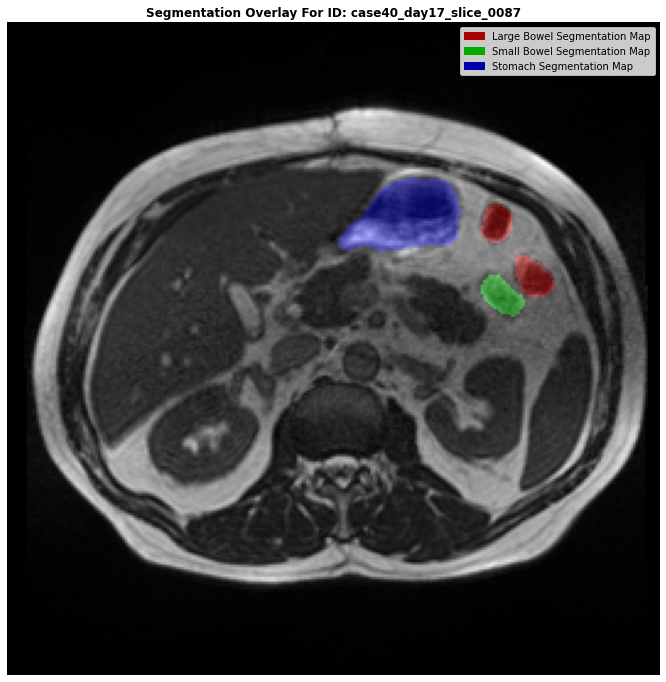



... SINGLE ID EXPLORATION COMPLETED ...



... ID (case148_day20_slice_0081) EXPLORATION BEGINS ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



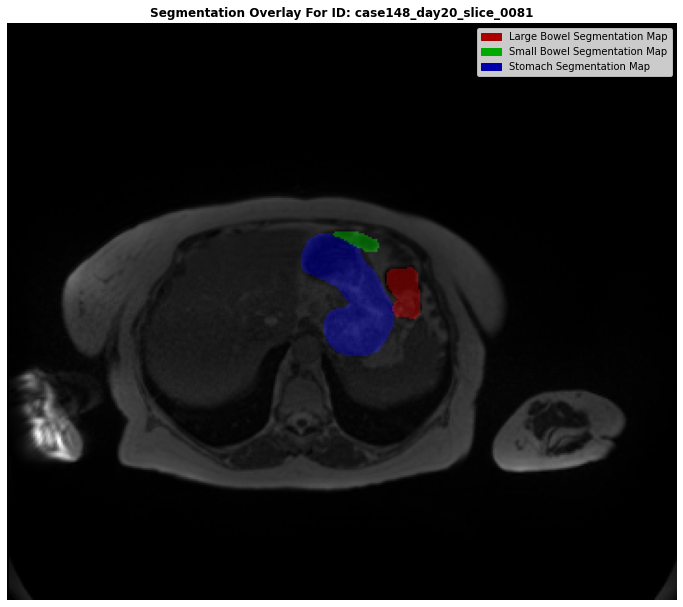



... SINGLE ID EXPLORATION COMPLETED ...



... ID (case114_day0_slice_0071) EXPLORATION BEGINS ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



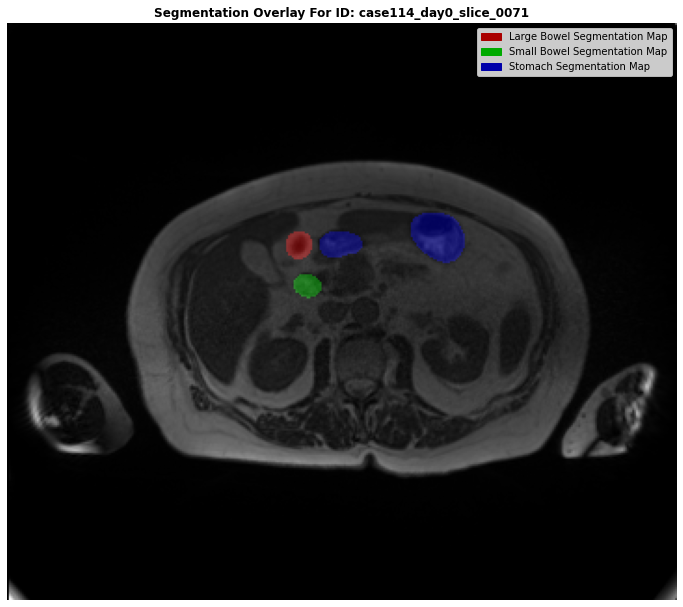



... SINGLE ID EXPLORATION COMPLETED ...



... ID (case124_day20_slice_0078) EXPLORATION BEGINS ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



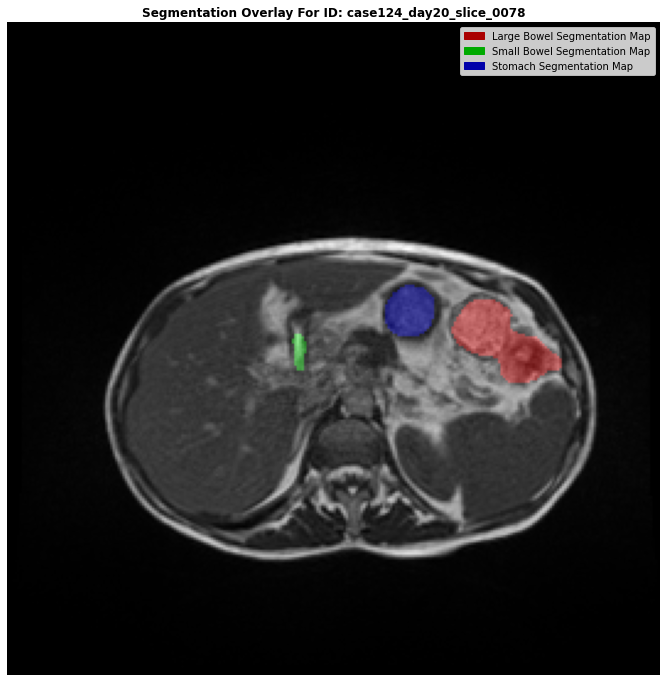



... SINGLE ID EXPLORATION COMPLETED ...



... ID (case32_day18_slice_0102) EXPLORATION BEGINS ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



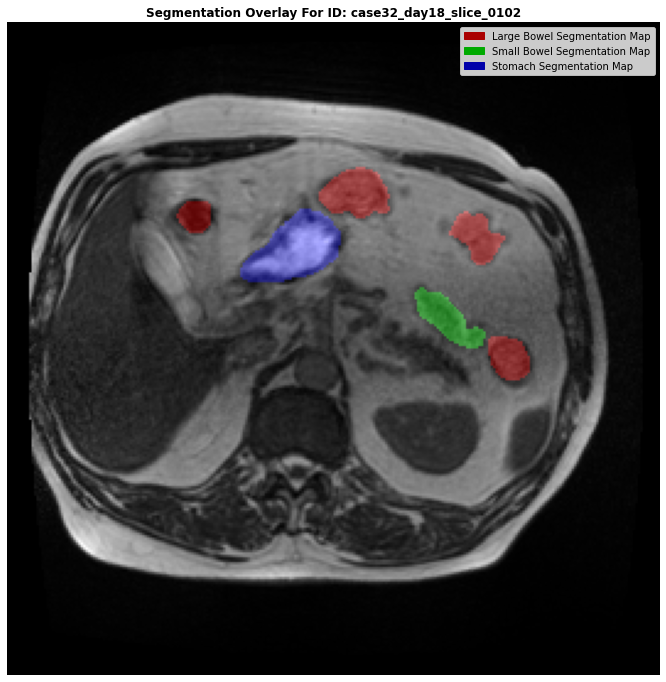



... SINGLE ID EXPLORATION COMPLETED ...




In [15]:
# Plot 5 random-ids where all tumor locales are present (max one id per case)
import random

N_TO_PLOT = 5
for _id in train_df[train_df.n_segs==3].groupby("case_id")["id"].first().sample(N_TO_PLOT):
    examine_id(_id)

**INVESTIGATE THE OCCURENCE SEGMENTATION MAP TYPES**

In [16]:
def get_seg_combo_str(row):
    seg_str_list = []
    if row["lb_seg_flag"]: seg_str_list.append("Large Bowel")
    if row["sb_seg_flag"]: seg_str_list.append("Small Bowel")
    if row["st_seg_flag"]: seg_str_list.append("Stomach")
    if len(seg_str_list)>0:
        return ", ".join(seg_str_list)
    else:
        return "No Mask"
train_df["seg_combo_str"] = train_df.progress_apply(get_seg_combo_str, axis=1)

fig = px.histogram(train_df, train_df["n_segs"].astype(str), color="seg_combo_str", title="<b>Number of Segmentation Masks Per Image</b>", 
                  labels={"x":"Number of Segmentation Masks Per Image", "seg_combo_str":"<b>Segmentation Masks Present</b>"})
fig.show()

  0%|          | 0/38496 [00:00<?, ?it/s]

**INVESTIGATE THE IMAGE SIZES**

In [17]:
fig = px.scatter(train_df.drop_duplicates(subset=["slice_w", "slice_h"]), x="slice_w", y="slice_h", 
                 size=train_df.groupby(["slice_w", "slice_h"])["id"].transform("count").iloc[train_df.drop_duplicates(subset=["slice_w", "slice_h"]).index], 
                 color="("+train_df.drop_duplicates(subset=["slice_w", "slice_h"])["slice_w"].astype(str)+","+train_df.drop_duplicates(subset=["slice_w", "slice_h"])["slice_h"].astype(str)+")", 
                 title="<b>Bubble Chart Showing The Various Image Sizes</b>",
                 labels={"color":"<b>Size Legend</b>", 
                         "size":"<b>Number Of Observations</b>",
                         "slice_h":"<b>Image Slice Height (pixels)</b>",
                         "slice_w":"<b>Image Slice Width (pixels)</b>"},
                 size_max=160)
fig.show()

**MASK SIZES/AREAS**




... EXAMINING FOR CASE WITH LARGE AMOUNT OF SEGMENTATION MASK ...


... ID (case134_day22_slice_0102) EXPLORATION BEGINS ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



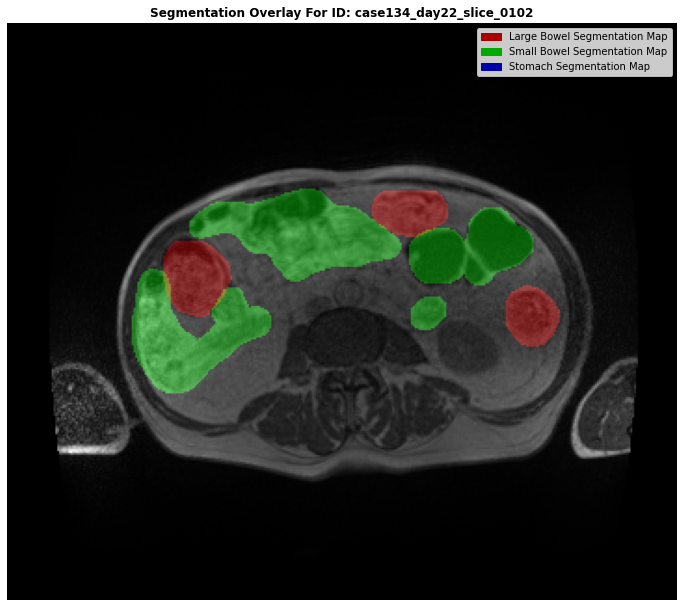



... SINGLE ID EXPLORATION COMPLETED ...




In [18]:
def get_mask_area(rle):
    return sum([int(x) for x in rle.split()[1::2]])

train_df["lb_seg_area"] = train_df.lb_seg_rle.apply(lambda x: None if pd.isna(x) else get_mask_area(x))
train_df["sb_seg_area"] = train_df.sb_seg_rle.apply(lambda x: None if pd.isna(x) else get_mask_area(x))
train_df["st_seg_area"] = train_df.st_seg_rle.apply(lambda x: None if pd.isna(x) else get_mask_area(x))

fig = px.histogram(train_df, ["lb_seg_area", "sb_seg_area", "st_seg_area"], title="<b>Mask Areas Overlaid</b>", barmode="overlay",
                  labels={"value":"<b>Mask Area</b>"})
fig.show()

print("\n\n\n... EXAMINING FOR CASE WITH LARGE AMOUNT OF SEGMENTATION MASK ...\n")
examine_id("case134_day22_slice_0102")

**IDENTIFY ANY HEURISTICS OR RULES REGARDING SEGMENTATION**

In [19]:
train_df["lb_seg_isolated"] = False
train_df["sb_seg_isolated"] = False
train_df["st_seg_isolated"] = False

train_df.loc[
    (train_df["lb_seg_flag"]==True) &
    (train_df["lb_seg_flag"]!=train_df["lb_seg_flag"].shift(1, fill_value=False)) &
    (train_df["lb_seg_flag"]!=train_df["lb_seg_flag"].shift(-1, fill_value=False)), "lb_seg_isolated"
] = True

train_df.loc[
    (train_df["sb_seg_flag"]==True) &
    (train_df["sb_seg_flag"]!=train_df["sb_seg_flag"].shift(1, fill_value=False)) &
    (train_df["sb_seg_flag"]!=train_df["sb_seg_flag"].shift(-1, fill_value=False)), "sb_seg_isolated"
] = True

train_df.loc[
    (train_df["st_seg_flag"]==True) &
    (train_df["st_seg_flag"]!=train_df["st_seg_flag"].shift(1, fill_value=False)) &
    (train_df["st_seg_flag"]!=train_df["st_seg_flag"].shift(-1, fill_value=False)), "st_seg_isolated"
] = True

train_df[train_df.lb_seg_isolated]

,id,f_path,n_segs,lb_seg_rle,lb_seg_flag,sb_seg_rle,sb_seg_flag,st_seg_rle,st_seg_flag,slice_h,...,day_num_str,day_num,slice_id,seg_combo_str,lb_seg_area,sb_seg_area,st_seg_area,lb_seg_isolated,sb_seg_isolated,st_seg_isolated
24885,case43_day18_slice_0038,/kaggle/input/uw-madison-gi-tract-image-segmen...,2,27813 3 28079 4 28345 5 28611 6 28877 7 29143 ...,True,NaN,False,39018 13 39281 17 39546 19 39811 20 40077 21 4...,True,266,...,day18,18,slice_0038,"Large Bowel, Stomach",168.0,NaN,343.0,True,False,False
31002,case138_day0_slice_0075,/kaggle/input/uw-madison-gi-tract-image-segmen...,3,27039 4 27303 8 27569 10 27834 12 28100 14 283...,True,34510 3 34773 7 35038 9 35302 12 35566 14 3583...,True,27020 12 27284 16 27549 17 27814 19 28079 20 2...,True,266,...,day0,0,slice_0075,"Large Bowel, Small Bowel, Stomach",150.0,169.0,573.0,True,False,False
31005,case138_day0_slice_0078,/kaggle/input/uw-madison-gi-tract-image-segmen...,3,27573 4 27837 9 28103 10 28368 13 28634 14 289...,True,32650 2 32914 11 33161 7 33179 13 33426 10 334...,True,26489 7 26750 14 27014 17 27280 18 27545 20 27...,True,266,...,day0,0,slice_0078,"Large Bowel, Small Bowel, Stomach",137.0,568.0,454.0,True,False,False
31008,case138_day0_slice_0081,/kaggle/input/uw-madison-gi-tract-image-segmen...,3,27310 6 27575 9 27840 12 28106 13 28372 13 286...,True,31827 7 32092 9 32357 11 32622 13 32888 15 331...,True,26220 6 26484 10 26748 13 27012 17 27277 19 27...,True,266,...,day0,0,slice_0081,"Large Bowel, Small Bowel, Stomach",117.0,942.0,558.0,True,False,False
31011,case138_day0_slice_0084,/kaggle/input/uw-madison-gi-tract-image-segmen...,3,26778 4 27043 7 27308 10 27574 12 27840 13 281...,True,30232 5 30497 8 30760 11 31023 15 31289 15 315...,True,24348 6 24612 10 24877 14 25141 17 25406 19 25...,True,266,...,day0,0,slice_0084,"Large Bowel, Small Bowel, Stomach",136.0,1304.0,771.0,True,False,False
31024,case138_day0_slice_0097,/kaggle/input/uw-madison-gi-tract-image-segmen...,3,25885 2 26149 6 26414 8 26679 9 26944 10 27209...,True,24589 12 24849 19 25112 22 25375 26 25637 30 2...,True,25407 2 25671 6 25937 8 26202 10 26468 10 2673...,True,266,...,day0,0,slice_0097,"Large Bowel, Small Bowel, Stomach",895.0,1529.0,130.0,True,False,False
31027,case138_day0_slice_0100,/kaggle/input/uw-madison-gi-tract-image-segmen...,2,27026 6 27204 3 27291 10 27468 7 27555 16 2773...,True,24851 14 25113 20 25376 24 25638 29 25900 33 2...,True,NaN,False,266,...,day0,0,slice_0100,"Large Bowel, Small Bowel",886.0,2367.0,NaN,True,False,False
31030,case138_day0_slice_0103,/kaggle/input/uw-madison-gi-tract-image-segmen...,2,26486 9 26750 14 27015 17 27281 18 27547 19 27...,True,25107 24 25369 30 25632 34 25895 37 26159 39 2...,True,NaN,False,266,...,day0,0,slice_0103,"Large Bowel, Small Bowel",828.0,2235.0,NaN,True,False,False
31033,case138_day0_slice_0106,/kaggle/input/uw-madison-gi-tract-image-segmen...,2,27739 4 28004 6 28269 8 28343 9 28535 8 28606 ...,True,24585 3 24849 7 25114 9 25379 11 25639 23 2590...,True,NaN,False,266,...,day0,0,slice_0106,"Large Bowel, Small Bowel",1076.0,1844.0,NaN,True,False,False
31036,case138_day0_slice_0109,/kaggle/input/uw-madison-gi-tract-image-segmen...,2,27743 4 28008 7 28273 8 28538 9 28597 14 28804...,True,25110 8 25373 16 25636 23 25900 26 26165 28 26...,True,NaN,False,266,...,day0,0,slice_0109,"Large Bowel, Small Bowel",869.0,2311.0,NaN,True,False,False



... ID (case7_day0_slice_0052) EXPLORATION BEGINS ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



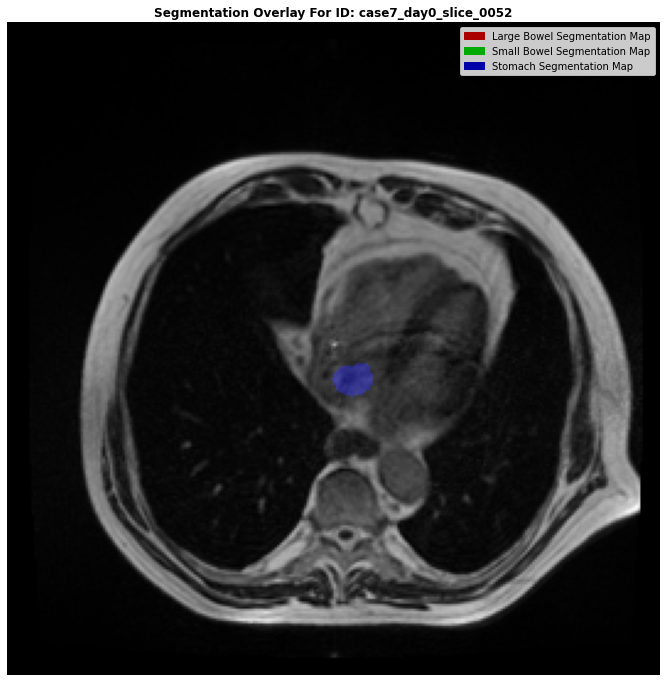



... SINGLE ID EXPLORATION COMPLETED ...




In [20]:
examine_id("case7_day0_slice_0052")

In [21]:
train_df["slice_count"] = train_df.id.apply(lambda x: int(x.rsplit("_", 1)[-1]))

print("\n... SLICE INFORMATION ...\n")
train_df.groupby(["case_id", "day_num"])["slice_count"].max().value_counts()


... SLICE INFORMATION ...



144    259
80      15
Name: slice_count, dtype: int64

In [22]:
slice_to_occurence_df = train_df.groupby("slice_count")[["lb_seg_flag", "sb_seg_flag", "st_seg_flag"]].sum().reset_index()
fig = px.bar(slice_to_occurence_df, 
             x="slice_count", y=["lb_seg_flag", "sb_seg_flag", "st_seg_flag"],
             orientation="v", labels={
                 "slice_count":"<b>Slice Number</b>", 
                 "value":"<b>Number Of Examples</b>",
             }, title="<b>Number of Examples Per Example For Our 3 Organs</b>")

fig.update_layout(
    legend_title="<b>Organ Type Legend</b>"
)
    
fig.show()

print("\n... WHICH SLICES ARE ALWAYS BLANK (NO SEG) BY LABEL ...\n")
keep_slice_blank_map = {_sh_lbl:slice_to_occurence_df[slice_to_occurence_df[f"{_sh_lbl}_seg_flag"]==0].slice_count.to_list() for _sh_lbl in ["lb", "sb", "st"]}
keep_slice_blank_map


... WHICH SLICES ARE ALWAYS BLANK (NO SEG) BY LABEL ...



{'lb': [1, 138, 139, 140, 141, 142, 143, 144],
 'sb': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 138, 139, 140, 141, 142, 143, 144],
 'st': [1,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144]}